# Q1) LiDAR-Camera Fusion

We are given the orientation of LiDAR and camera's frames and the translation of camera's center from LiDAR. We have also been told that the sensors are positioned such that the camera’s Z-axis and the LiDAR’s X-axis are perfectly, now 
1. The first task is to find out the transformation between the two frames in homogeneous form and XYZ Euler angles (RPY)-translation form.
2. The second task is to project LiDAR's points onto the image plane.

In [1]:
# Load Lidar points
import numpy as np

def load_velodyne_points(points_path):
    points = np.fromfile(points_path, dtype=np.float32).reshape(-1, 4)
    points = points[:,:3]                # exclude reflectance values, becomes [X Y Z]
    points = points[0::5,:]              # remove every 5th point for display speed (optional)
    points = points[(points[:,0] > 5)]   # remove all points behind image plane (approximate)
    return points

## Part - 1: Transformation between the two frames in XYZ Euler angles (RPY)-translation form and homogeneous form.



In [2]:
# XYZ Euler angles

# Sequence of rotation is first about (moving) x, then y and then z.
from math import pi, cos as c, sin as s

# Camera in lidar frame
alpha_x = pi/2; beta_y = -pi/2; gamma_z = 0
trans_x = 0.27; trans_y = 0.06; trans_z = -0.08

# Lidar in camera frame
alpha_x_lc = pi/2; beta_y_lc = 0; gamma_z_lc = pi/2
trans_x_lc = 0.06; trans_y_lc = -0.08; trans_z_lc = -0.27

R_x = np.array([[1, 0, 0], [0, c(alpha_x_lc), -s(alpha_x_lc)], [0, s(alpha_x_lc), c(alpha_x_lc)]])
R_y = np.array([[c(beta_y_lc), 0, s(beta_y_lc)], [0, 1, 0], [-s(beta_y_lc), 0, c(beta_y_lc)]])
R_z = np.array([[c(gamma_z_lc), -s(gamma_z_lc), 0], [s(gamma_z_lc), c(gamma_z_lc), 0], [0, 0, 1]])

R_c_l = np.dot(R_x, np.dot(R_y, R_z))
R_c_l[(np.abs(R_c_l) < 1e-10)] = 0



print("Relation of lidar in camera frame:")
print("Euler Angles(XYZ): ")
print("About X axis (roll): ", np.degrees(alpha_x_lc))
print("About Y axis (pitch): ", np.degrees(beta_y_lc))
print("About Z axis (yaw): ", np.degrees(gamma_z_lc))
print("Translation:\n x = %f, y = %f, z = %f" % (trans_x_lc, trans_y_lc, trans_z_lc))
R_c_l

Relation of lidar in camera frame:
Euler Angles(XYZ): 
About X axis (roll):  90.0
About Y axis (pitch):  0.0
About Z axis (yaw):  90.0
Translation:
 x = 0.060000, y = -0.080000, z = -0.270000


array([[ 0., -1.,  0.],
       [ 0.,  0., -1.],
       [ 1.,  0.,  0.]])

### Homogeneous form


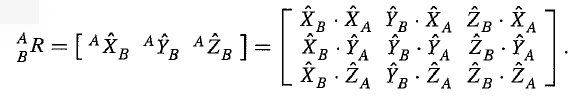

** A and B are a and b below **

aRb above represents b in a's frame. Over here, we first represent the camera's frame (b) in LiDAR's frame (a) and then invert the matrix as the question is presented with respect to the camera. The inverted matrix would thus give LiDAR's frame in camera's frame.

** Please note that the a and b notation in below image is as per inverted matrix notation and not the initial representation of camera's frame in LiDAR's frame. To avoid any confusion, reiterating here that camera's frame is b (so b is C) and LiDAR's frame is a (and a is L). Please ignore notation used in below image, it is for inverted matrix.**

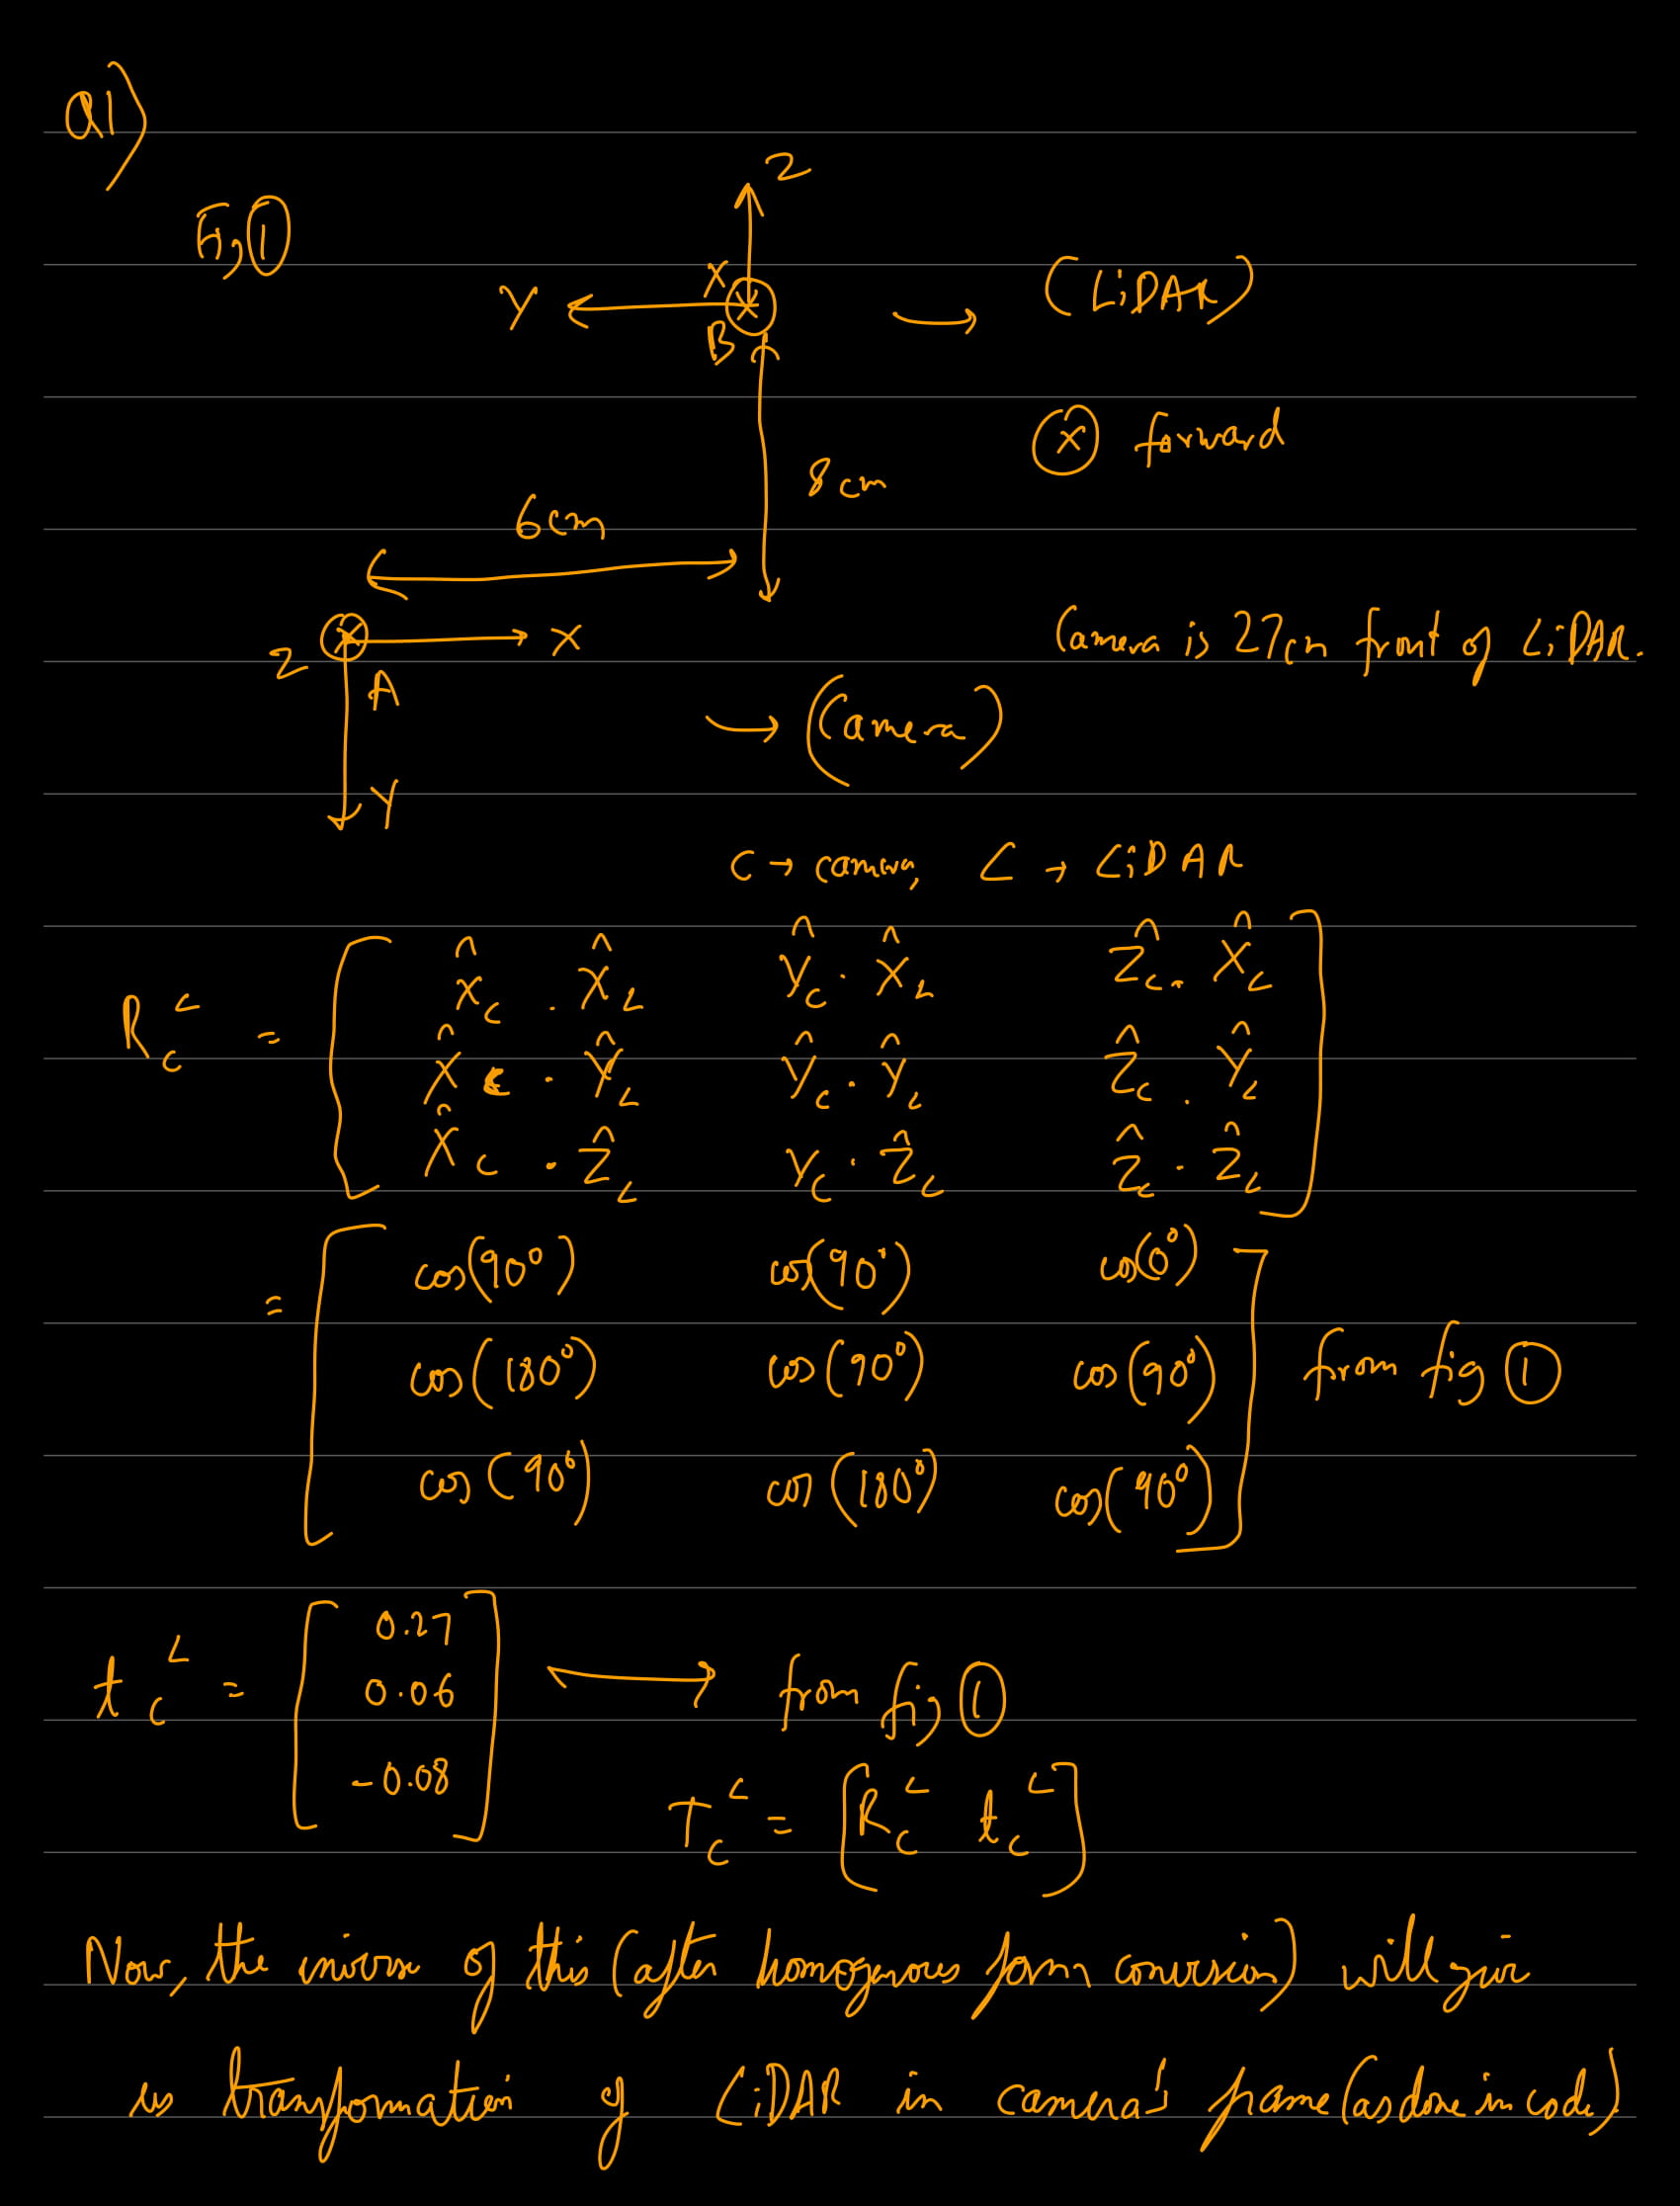

In [3]:
# Homogeneous form
# T_a_b : Represents a in b's frame
from math import pi, cos as c

R_c_l = np.array([[c(pi/2), c(pi/2), c(0)], [c(pi), c(pi/2), c(pi/2)], [c(pi/2), c(pi), c(pi/2)]])
R_c_l[(np.abs(R_c_l) < 1e-10)] = 0

T_c_l = np.identity(4)
T_c_l[0:3, 0:3] = R_c_l
T_c_l[0, 3] = trans_x; T_c_l[1, 3] = trans_y; T_c_l[2, 3] = trans_z
T_l_c = np.linalg.inv(T_c_l)
print("Homogeneous matrix, Lidar in Camera frame:\n", T_l_c)

Homogeneous matrix, Lidar in Camera frame:
 [[-0.   -1.   -0.    0.06]
 [-0.   -0.   -1.   -0.08]
 [ 1.    0.    0.   -0.27]
 [ 0.    0.    0.    1.  ]]


## Part - 2: Project LiDAR's points onto the image plane

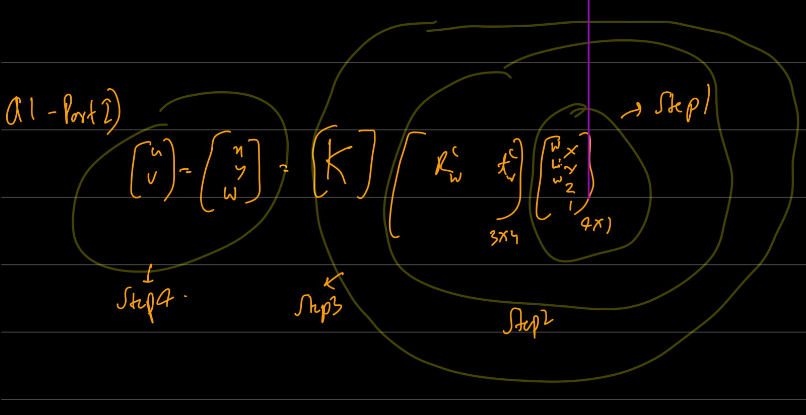

This is fairly straightforward now that we have all the matrices on the right hand of the equation, we just need to find the (u,v) for each point using the camera equation in the image above.

* Step 1: Converting points in LiDAR's frame into homogeneous coordinates.
* Step 2: Transforming points in LiDAR's frame (points_l) to Camera frame (points_c).
* Step 3: Matrix multiplying points in Camera frame (points_c) with K, intrinsic calibration matrix to get pixel coordinate values in homogeneous form.
* Step 4: Dividing by last element to get actual Pixel coordinate values.

In [4]:
# Projecting points to image
points_l = load_velodyne_points('./lidar-points.bin')
(r, c) = points_l.shape
ones = np.ones((r, 1))
# Step 1
points_l = np.hstack((points_l, ones))
# Step 2
points_c = np.dot(T_l_c, points_l.T)
points_c = points_c[0:3, :]

K = np.array([[7.215377e+02, 0.000000e+00, 6.095593e+02], [0.000000e+00, 7.215377e+02, 1.728540e+02], [.000000e+00, 0.000000e+00, 1.000000e+00]])

# Step 3
pixs = np.dot(K, points_c)
# Step 4
pixs[0, :] /= pixs[2, :]
pixs[1, :] /= pixs[2, :]

u = pixs[0, :]; v = pixs[1, :]; intensity = pixs[2, :]

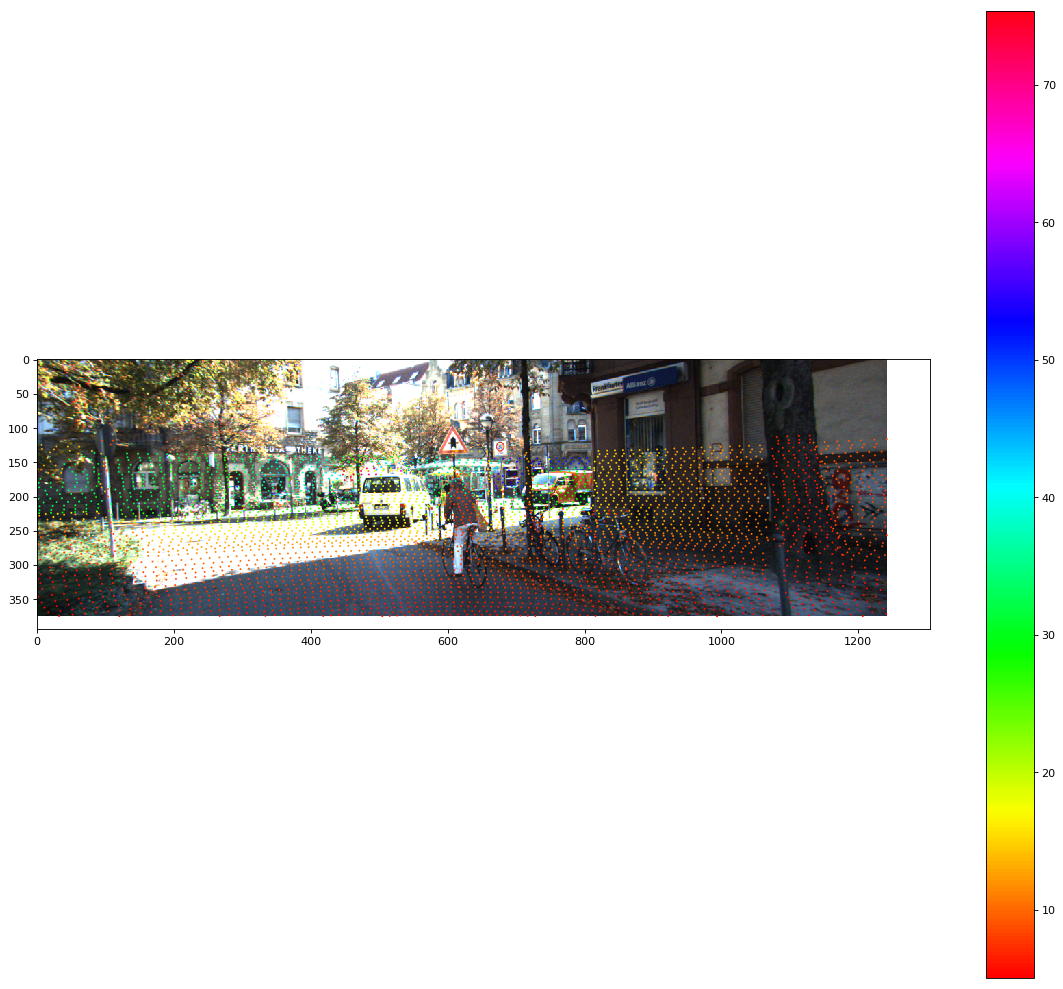

In [6]:
# %matplotlib notebook
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
img=mpimg.imread('./image.png')
imgplot = plt.imshow(img)

(r,c,d) = img.shape

# Filter points in image's FOV
U = []; V = []; Int = []
for i in range(u.shape[0]):
    if((u[i] > 0 and v[i] > 0) and (u[i] < c and v[i] < r)):
        U.append(u[i]); V.append(v[i]); Int.append(intensity[i])

plt.scatter(U, V, c=Int, s=0.5, cmap='hsv')
plt.colorbar()

plt.show()
# plt.savefig('lidar_on_image.png', bbox_inches='tight')